# MOM-SIS 0.1$^\circ$ Diagnostics

This notebook calculates and retains key diagnostics from our mom01v5 simulations. The following experiments are included:

| Experiment Name | Description |
|-----------------|-----------------|
|GFDL50 | Original simulation with 50 vertical levels. Ran from Levitus for about 60 years, but data output only saved from about year 40.|
|KDS75 | Branched from GFDL50 at year 45 (re-zeroed), but with Kial Stewart's 75 level scheme. Has now run for 103 years. Years 90-100 have 5-daily output.|
| KDS75_wind | Short (5-year) Antarctic wind perturbation case, branched from KDS75 at year 40.|
| KDS75_PI | Paul Spence's Poleward Intensification wind experiment. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade|
| KDS75_UP | Paul Spence's Increased winds case. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade. (In Progress) |

**Last updated March 30 2017.**

https://github.com/OceansAus/cosima-cookbook

In [2]:
DataDir = '/g/data3/hh5/tmp/cosima/mom01v5'

### Experiments

In [3]:
expts = ['GFDL50','KDS75','KDS75_PI','KDS75_wind']

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync
from dask.diagnostics import ProgressBar

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

#import datashader

In [5]:
pbar = ProgressBar()
pbar.register()

In [6]:
dask.set_options(get=dask.multiprocessing.get, num_workers=4)

## Wind Stress fields
The following code block shows the zonal- and time-averaged wind stress forcing for each experiment.

GFDL50 - Already Processed
KDS75 - Already Processed
KDS75_PI - Already Processed
KDS75_wind - Already Processed


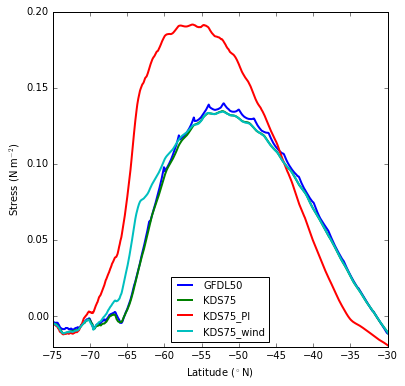

In [7]:
plt.figure(figsize=(6,6))
for e in expts:
    ExpDir = os.path.join(DataDir,e)

    # Is there any processed data to load?
    AvgeWindFile = os.path.join(ExpDir,'TauX_Last5Years.nc')
    if os.path.exists(AvgeWindFile):
        print (e + ' - Already Processed')
    else: 
        # average last 20 outputs (~ 5 years)
        FileList = [f for f in os.listdir(ExpDir) if f.startswith('output')]
        FileList.sort()
        FileString = ''
        for f in FileList[-20:]:
            FileString  = FileString + ' ' + ExpDir + '/' + f + '/ocean_month.nc' 

        NCRA_COMMAND = "ncra " + FileString + ' -v tau_x ' + AvgeWindFile
        print (NCRA_COMMAND)
        print (" ")
        result = os.system(NCRA_COMMAND)
        if result != 0:
            print ("\nERROR code for NCRA: %s" % (result))

    nc = Dataset(AvgeWindFile)
    tau = nc.variables['tau_x'][:,:,:]
    lat = nc.variables['yu_ocean'][:]
    nc.close()

    tau_bar = np.ma.mean(tau,axis=2)[0,:]
    plt.plot(lat,tau_bar,linewidth=2,label=e)

plt.xlim([-75,-30])
plt.ylim([-0.02,0.2])
plt.xlabel('Latitude ($^\circ$N)')
plt.ylabel('Stress (N m$^{-2}$)')
plt.legend(loc=8,fontsize=10)
plt.savefig('figures/WindStress.pdf')

# Drake Passage Transport
First let's look at a timeseries of Drake Passage transport from each of our comparison runs. For this we will use tx_trans, summed across Drake Passage latitudes (x=2100, y = 225:650).


In [7]:
def calculate_transport(OceanFile):
    try:
        dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
        tx_trans = dsx.tx_trans[0,:,225:650,2100]
        
        transport = tx_trans.sum()

        if np.isnan(transport.values):
            transport = np.nan
        elif transport.values > tx_trans.valid_range[1]:
            transport = np.nan
    except:
        transport = np.nan
    
    return OceanFile, transport

In [8]:
drake_transport = {}
for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()
    
    # Is there any processed data to load?
    MetricsFile = 'SimulationMetrics.pkl'
    if os.path.exists(MetricsFile):
        transports = pickle.load(open(MetricsFile, 'rb'))
        
        ProcessedFiles = transports.keys()
        FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
    else:
        transports = {}

        # Make this so it actually decides which files have been processed.
        FilesToProcess = FileList

    delayed_transports = [delayed(calculate_transport)(fn) for fn in FilesToProcess]
    data = delayed(list)(delayed_transports)
    
    transports.update({x[0]: x[1] for x in data.compute(num_workers=4) if not np.isnan(x[1])})
    pickle.dump( transports, open( MetricsFile, "wb" ))
    
    drake_transport[expt] = xr.concat( [transports[fn] for fn in FileList if fn in transports], dim='time')

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


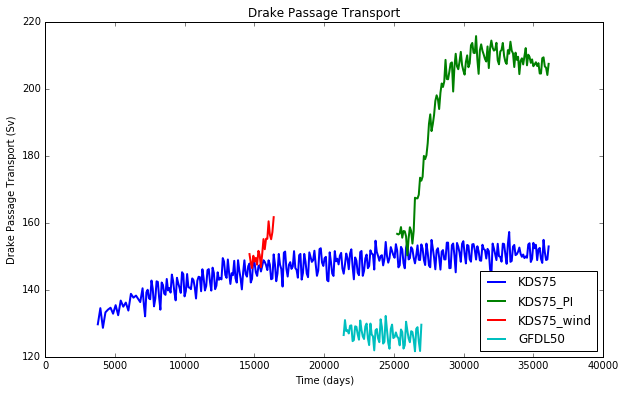

In [9]:
plt.figure(figsize=(10,6))

for expt in drake_transport:
    drake_transport[expt].plot(label=expt, linewidth=2)

plt.legend(loc='lower right')
plt.ylabel('Drake Passage Transport (Sv)')
plt.xlabel('Time (days)')
plt.title('Drake Passage Transport')
plt.savefig('figures/DPTrans.pdf')

# Scalar Quantities
Look at some quantities that are saved in ocean_scalar.nc.

In [10]:
def extract_data(f):
    dataset = Dataset(f)
    
    data = {}
    for v in dataset.variables.values():
        if 'time' in v.dimensions and 'scalar_axis' in v.dimensions:
            data[v.name] = v[:].flatten()
    index = pd.to_datetime(dataset['time'][:], unit='D')
    df = pd.DataFrame(index=index, data=data)
    return df

scalar_quantities = {}

for expt in expts:
    expdir = os.path.join(DataDir,expt)
    DataFileList = glob(os.path.join(expdir, 'output*/ocean_scalar.nc'))

    frames = [ delayed(extract_data)(f) for f in DataFileList]
    if len(frames) > 0:
        scalar_quantities[expt] = delayed(pd.concat)(frames).compute(num_workers=4)

[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  0.7s


In [11]:
scalar_quantities['KDS75'].describe().T

,count,mean,std,min,25%,50%,75%,max
eta_global,1067.0,-1.593142e-02,6.125017e-03,-2.507647e-02,-2.219637e-02,-1.536169e-02,-9.469000e-03,-7.689955e-03
ke_tot,1067.0,3.207240e+03,4.296194e+01,3.069407e+03,3.178241e+03,3.207977e+03,3.236352e+03,3.337936e+03
pe_tot,1067.0,2.923421e+10,2.127271e+05,2.923390e+10,2.923395e+10,2.923397e+10,2.923405e+10,2.923417e+10
rhoave,1067.0,1.037503e+03,8.463541e-03,1.037508e+03,1.037511e+03,1.037512e+03,1.037513e+03,1.037514e+03
salt_global_ave,1067.0,3.471841e+01,2.842059e-04,3.471807e+01,3.471810e+01,3.471812e+01,3.471815e+01,3.471822e+01
salt_surface_ave,1067.0,3.457143e+01,4.076764e-02,3.446720e+01,3.454469e+01,3.457692e+01,3.460148e+01,3.464626e+01
temp_global_ave,1067.0,3.585202e+00,7.093610e-03,3.571681e+00,3.579998e+00,3.584526e+00,3.589744e+00,3.604700e+00
temp_surface_ave,1067.0,1.818324e+01,1.873723e-01,1.782940e+01,1.807038e+01,1.816873e+01,1.831075e+01,1.849554e+01
total_net_sfc_heating,1067.0,6.522485e-02,4.466529e+00,-7.733866e+00,-4.228704e+00,1.705252e+00,3.968884e+00,5.729136e+00
total_ocean_calving,1067.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


CPU times: user 831 ms, sys: 1.1 s, total: 1.93 s
Wall time: 775 ms


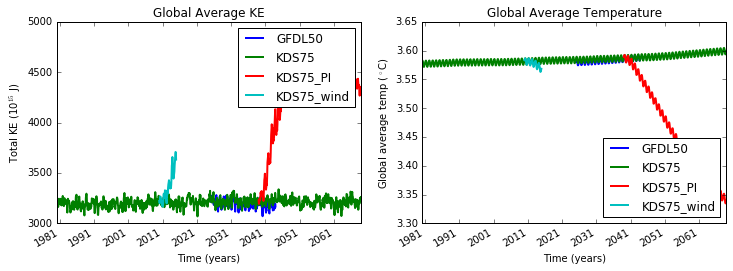

In [12]:
%%time

plt.figure(figsize=(12,4))

for expt in expts:
    plt.subplot(121)
    scalar_quantities[expt].ke_tot.plot(label=expt, linewidth=2)

    plt.subplot(122)
    scalar_quantities[expt].temp_global_ave.plot(label=expt, linewidth=2)

plt.subplot(121)
plt.legend(loc='upper right')
plt.ylabel('Total KE (10$^{15}$ J)')
plt.xlabel('Time (years)')
plt.title('Global Average KE')

plt.subplot(122)
plt.legend(loc='lower right')
plt.ylabel('Global average temp ($^\circ$C)')
plt.xlabel('Time (years)')
plt.title('Global Average Temperature')

plt.savefig('figures/Scalars.pdf')

# Overturning Circulation
Next, let's look at overturning circulation in density space using ty_trans_rho. We will zonally average this diagnostic, without accounting for the tripolar grid, so ignore the Arctic.

In [13]:
def calculate_Ψ(expt, count = 4):
    ExpDir = os.path.join(DataDir, expt)

    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()

    Ψ = 0
    for OceanFile in FileList[-count:]: 

        dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4', chunks={'potrho':5})
        
        psi_partial = dsx.ty_trans_rho.isel(time=0).sum('grid_xt_ocean').cumsum('potrho')
        dsx.close()

        Ψ = Ψ + psi_partial

    Ψ_avg = Ψ/count

    return Ψ_avg


In [14]:
def plot_psi(psi, expt, clev=np.arange(-20,20,2)):
    #x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

    plt.contourf(psi.grid_yu_ocean, psi.potrho, psi, cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    #plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

In [21]:
%%time
psi_KDS = calculate_Ψ('KDS75', count=40)
psi_GFDL = calculate_Ψ('GFDL50', count=40)
psi_KDS_PI = calculate_Ψ('KDS75_PI', count=40)

CPU times: user 7.85 s, sys: 187 ms, total: 8.04 s
Wall time: 11.8 s


In [16]:
%%time 
psi_KDS.load()

[########################################] | 100% Completed |  6min 28.4s
CPU times: user 12.7 s, sys: 2.76 s, total: 15.4 s
Wall time: 6min 28s


<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)>
array([[  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.188731e-05,
         -2.138354e-04,  -3.533488e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -9.296458e-05,
         -2.696876e-04,  -3.849246e-04],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -1.666754e-04,
         -4.045704e-04,  -4.449742e-04],
       ..., 
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   5.209193e-04,
          2.783439e-04,   1.187926e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   5.209193e-04,
          2.783439e-04,   1.187926e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   5.209193e-04,
          2.783439e-04,   1.187926e-05]])
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * potrho         (potrho) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 ...

In [17]:
psi_GFDL.load()

[########################################] | 100% Completed |  6min 40.9s


<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)>
array([[  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.538523e-03,
         -1.947735e-03,  -1.092834e-03],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.561778e-03,
         -1.962980e-03,  -1.122807e-03],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,  -2.564085e-03,
         -1.940852e-03,  -1.190930e-03],
       ..., 
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   5.648739e-04,
          3.267157e-04,   6.046022e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   5.648739e-04,
          3.267157e-04,   6.046022e-05],
       [  0.000000e+00,   0.000000e+00,   0.000000e+00, ...,   5.648739e-04,
          3.267157e-04,   6.046022e-05]])
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * potrho         (potrho) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 ...

In [18]:
psi_diff = psi_KDS - psi_GFDL

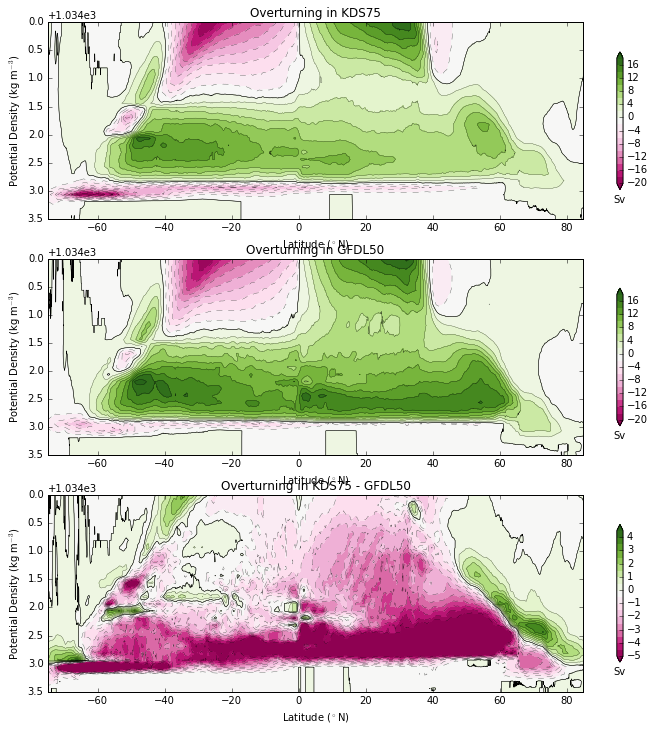

In [19]:
plt.figure(figsize=(12,12))

plt.subplot(311)
plot_psi(psi_KDS, 'KDS75')

plt.subplot(312)
plot_psi(psi_GFDL, 'GFDL50')

plt.subplot(313)
plot_psi(psi_diff, 'KDS75 - GFDL50', clev = np.arange(-5,5,0.5))

In [20]:
print ('For densities exceeding: ', psi_KDS.potrho[68].values)
print ('And at latitude:', psi_KDS.grid_yu_ocean[500].values)
print ('GFDL50 Min', np.min(psi_GFDL[68:,500]).values)
print ('KDS75 Min', np.min(psi_KDS[68:,500]).values)

For densities exceeding:  1036.5625
And at latitude: -59.4677023349844
GFDL50 Min -5.9935849597851085
KDS75 Min -21.640249511152653


In [22]:
%%time 
psi_KDS_PI.load()
psi_diff = psi_KDS_PI - psi_KDS

[########################################] | 100% Completed |  6min 53.7s
CPU times: user 14.7 s, sys: 2.65 s, total: 17.3 s
Wall time: 6min 54s


[########################################] | 100% Completed |  6min 50.1s
[########################################] | 100% Completed |  6min 19.8s
[########################################] | 100% Completed |  6min 11.0s
[########################################] | 100% Completed |  6min 13.9s
[########################################] | 100% Completed |  6min 11.5s
[########################################] | 100% Completed |  6min 10.1s


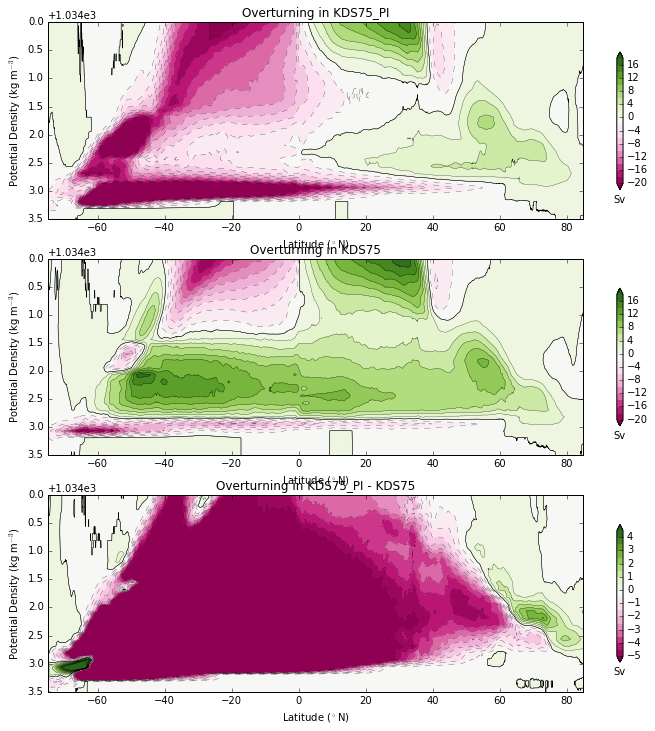

In [23]:
plt.figure(figsize=(12,12))

plt.subplot(311)
plot_psi(psi_KDS_PI, 'KDS75_PI')

plt.subplot(312)
plot_psi(psi_KDS,'KDS75')

plt.subplot(313)
plot_psi(psi_diff, 'KDS75_PI - KDS75', clev = np.arange(-5,5,0.5))

# Indo Throughflow??
* Still a work in progress ....

In [120]:
def calculate_lombok_transport(OceanFile):
    try:
        dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
        ty_trans = dsx.ty_trans[0,:,1158,354:361]
        
        transport = ty_trans.sum()

        if np.isnan(transport.values):
            transport = np.nan
        elif transport.values > ty_trans.valid_range[1]:
            transport = np.nan
    except:
        transport = np.nan
    
    return OceanFile, transport

In [126]:
Expdir = os.path.join(DataDir,expts[1])
FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
FileList.sort()
transport = []
for f in FileList:
    transport = xr.concat(transport,calculate_lombok_transport(OceanFile))
    
transport.plot(linewidth=2)

ValueError: must supply at least one object to concatenate

<xarray.DataArray 'ty_trans' ()>
array(-1.473966432557063)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 -8.568
('/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output383/ocean.nc', <xarray.DataArray 'ty_trans' ()>
array(-1.473966432557063)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 -8.568)


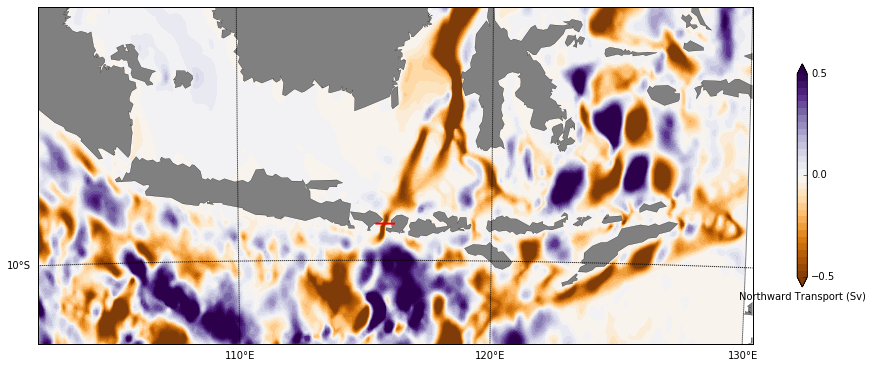

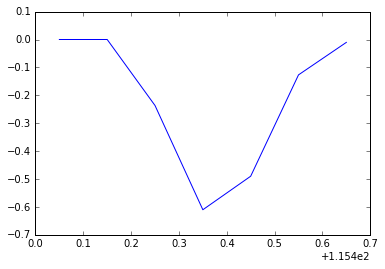

In [121]:
## test code to play with computation of lombok transport

# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,1100:1250,200:500]
x = dsx.xt_ocean[200:500]
y = dsx.yu_ocean[1100:1250]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Lombok, etc.
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-258,llcrnrlat=-13,urcrnrlon=-230,urcrnrlat=0,projection='stere',resolution='l',lon_0=-245,lat_0=-7)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
xx = np.array([X[58,154], X[58,161]])+360
yy = np.array([Y[58,154],Y[58,161]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')

# calculate timeseries of transport through each strait

plt.figure()
plt.plot(x[154:161]+360,transport[58,154:161])
lombok_transport = np.sum(transport[58,154:161])

print(lombok_transport)

tmp = calculate_lombok_transport(OceanFile)
print(tmp)

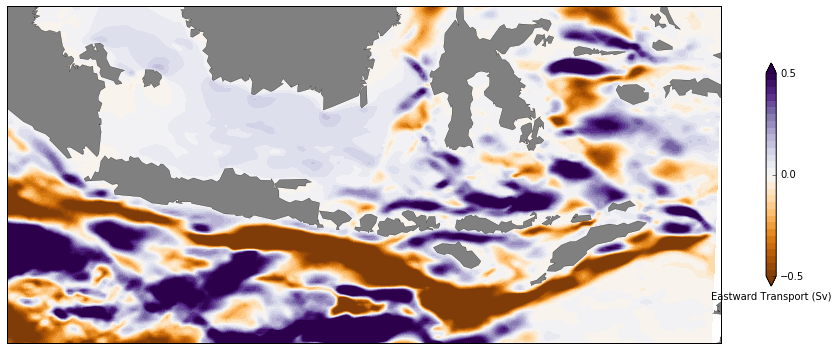

In [42]:
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output385/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
tx_trans = dsx.tx_trans[0,:,1100:1250,200:500]
x = dsx.xu_ocean[200:500]
y = dsx.yt_ocean[1100:1250]
transport = tx_trans.sum(axis=0)
xv, yv = np.meshgrid(x, y)

plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-258,llcrnrlat=-13,urcrnrlon=-230,urcrnrlat=0,projection='stere',resolution='l',lon_0=-245,lat_0=-7)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
#map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
#map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Eastward Transport (Sv)')

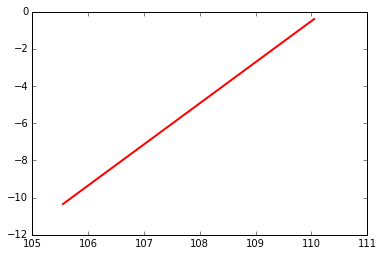

In [80]:
plt.plot(xx,yy,linewidth=2,color='r')



In [114]:
lombok_transport

<xarray.DataArray 'ty_trans' ()>
array(-1.473966432557063)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 -8.568

In [115]:
tmp

('/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output383/ocean.nc',
 <xarray.DataArray 'tx_trans' ()>
 array(0.0)
 Coordinates:
     yt_ocean  float64 -8.617
     time      float64 3.591e+04)